# Programa de bicicletas compartidas (Bicycle share scheme)


Sistema práctico y al alcance de todos, en donde el usuario puede alquilar fácilmente una bicicleta y/o una bicicleta eléctrica desde cierta posición en particular, los cuales son estacionamientos específicos según la entidad que entrega el servicio, y con la opción de devolverla en otro punto de estacionamiento.

Este sistema toma un papel fundamental en la detección de eventualidades y análisis del comportamiento dentro de una ciudad. Esto debido a que, a diferencia de transportes como buses, metro o automóviles, gracias a los sensores incorporados se puede registrar la información exacta del viaje, como por ejemplo la duración, punto de inicio y punto de llegada.


## Descripción del prolema
Poniéndonos en la situación de que somos parte del equipo de la empresa Rent-Cycle en Wachington DC, y nuestro Team Leader nos da la tarea de implementar un modelo que nos permita **predecir la cantidad de bicicletas que se alquilan** según la información contenida en el dataset puesto a disposición.

**Tipo de problema**: Regresión, ya que la variable objetivo a predecir es un valor numérico

## Procedimiento
1. [Librerías](#id1)
2. [Importación de archivos](#id2)
3. [EDA: Análisis exploratorio de datos](#id3)
    <br>3.1. [Búsqueda de valores faltantes](#id3.1)
    <br>3.2. [Correlación de variables](#id3.2)
    <br>3.3. [Distribuciones](#id3.3)
4. [Feature engineering](#id4)
5. [Pre-procesamiento](#id5)
6. [Modelos de entrenamiento](#id6)
    <br>6.1. [Random Forest](#id6.1)
    <br>6.2. [XGBoost](#id6.2)
    <br>6.3. [Lightgbm](#id6.3)
7. [Pruebas](#id7)


## 1. Librerías
<div id='id1'/>


In [218]:
import math
import statsmodels.api as sm
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import StackingRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

## 2. Importación de archivos
<div id='id2'/>

In [10]:
train_df = pd.read_excel('Dataset/bike_train.xlsx')
test_df = pd.read_excel('Dataset/bike_test_act.xlsx')

In [11]:
print(train_df.shape)
train_df.head(2)

(11999, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40


In [12]:
print(test_df.shape)
test_df.head(2)

(5380, 14)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,12000,2012-05-20,2,1,5,4,0,0,0,1,0.52,0.5000,0.68,0.0896
1,12001,2012-05-20,2,1,5,5,0,0,0,1,0.50,0.4848,0.72,0.1045


## 3. EDA: Análisis exploratorio de datos
<div id='id3'/>

### Búsqueda de valores faltantes
<div id='id3.1'/>

> No presentan valores faltantes ambos datasets

In [5]:
train_df.isna().sum().sum()

0

In [6]:
test_df.isna().sum().sum()

0

In [7]:
train_df.drop_duplicates(subset = ['dteday', 'hr']).shape

(11999, 17)

In [8]:
test_df.drop_duplicates(subset = ['dteday', 'hr']).shape

(5380, 14)

### Correlación de variables
<div id='id3.2'/>

Eliminamos la variable `instant` y `dteday`
> Se pensó usar la columna dteday en un principio para incluirla en la aplicación de un modelo de Serie temporal, pero no se contaba con datos de horas completas (71 días con registros de horas incompletas)

In [9]:
train_df.groupby(['dteday', 'weekday'])['hr'].count()[train_df.groupby(['dteday', 'weekday'])['hr'].count() < 24]

dteday      weekday
2011-01-02  0          23
2011-01-03  1          22
2011-01-04  2          23
2011-01-05  3          23
2011-01-06  4          23
                       ..
2012-02-29  3          23
2012-03-11  0          23
2012-04-02  1          23
2012-04-11  3          23
2012-05-20  0           4
Name: hr, Length: 71, dtype: int64

In [13]:
train_df.drop(labels = ['instant', 'dteday'], axis = 1, inplace = True)

In [14]:
import itertools
from sklearn.metrics import confusion_matrix

def make_correlation(df, figsize = (20,10), text_size = 8):
  
    cm = df.corr().values
    n_classes = cm.shape[0]

    fig, ax = plt.subplots(figsize = figsize)
    cax = ax.matshow(cm, cmap = plt.cm.Blues)

    # Establecemos labels para las classes
    labels = df.columns

    # Label the axes
    ax.set(title = "Matriz de correlación lineal",
            xticks = np.arange(n_classes),
            yticks = np.arange(n_classes),
            xticklabels = labels, # axes se etiquetarán con nombres de clase (si existen) o enteros
            yticklabels = labels)
  
    # Establecemos x-axis labels to bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Ajustas tamaño label
    ax.yaxis.label.set_size(text_size)
    ax.xaxis.label.set_size(text_size)
    ax.title.set_size(text_size)
    fig.autofmt_xdate(rotation=70)


    # Establecemos threshold para diferentes colores
    threshold = (cm.max() + cm.min())/2.

    # Dibujamos el texto en cada celda
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{round(cm[i,j], 2)}%",
             horizontalalignment = "center",
             color = "white" if cm[i, j] > threshold else "black",
             size = text_size)

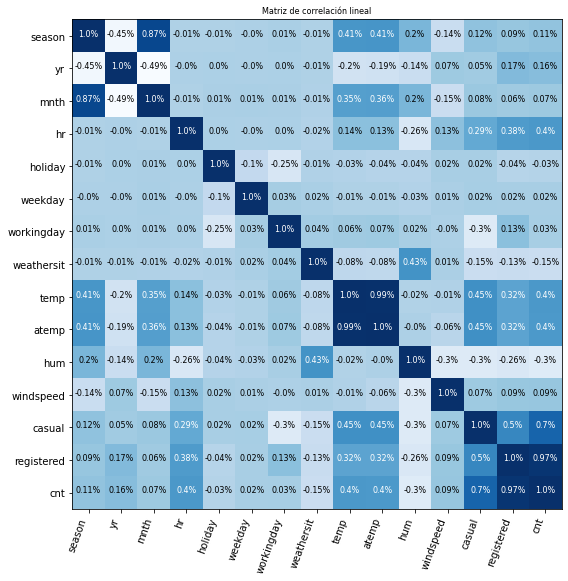

In [15]:
make_correlation(train_df)

<div id='idconc'/>

[Regresar a Feature engineering](#idfeat)

**Conclusiones**:
- Correlación con `cnt`

>`casual`(0.7) y `registered`(0.9) / Cabe resaltar que casual + registered componen la variable cnt, dado que el objetivo a predecir es cnt, se podría trata de 2 maneras:

     - Eliminar cnt, y realizar 2 regresiones (casual y registered) y luego sumar ambos resultados para obtener la predicción
     
     - Eliminar casual y registered para tener una única variable a predecir

- Correlación entre `season` y `mnth` (0.87)

> Debido a su alta correlación lineal, se decidirá eliminar una de las dos


- Correlación entre `temp` y `atemp` (0.99)

> Debido a su alta correlación lineal, se decidirá eliminar una de las dos

     - Dato a tener en cuenta : En la formula de sensación térmica por frio o calor, atemp recibe como variable independiente a la temperatura
     
- Correlación casi nula con `cnt`

> Se considera un rango entre -0.1 a 0.1

      - `mnth`(0.07), `workingday`(0.03), `weekday`(0.02), `holiday` (-0.03), `windspeed` (0.09)   


In [13]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
season,11999.0,2.210684,1.088798,1.00,1.0000,2.0000,3.0000,4.0000
yr,11999.0,0.279523,0.448784,0.00,0.0000,0.0000,1.0000,1.0000
mnth,11999.0,5.530294,3.433005,1.00,3.0000,5.0000,8.0000,12.0000
hr,11999.0,11.556630,6.911891,0.00,6.0000,12.0000,18.0000,23.0000
holiday,11999.0,0.027752,0.164269,0.00,0.0000,0.0000,0.0000,1.0000
weekday,11999.0,3.009334,2.005264,0.00,1.0000,3.0000,5.0000,6.0000
workingday,11999.0,0.684057,0.464910,0.00,0.0000,1.0000,1.0000,1.0000
weathersit,11999.0,1.435036,0.650894,1.00,1.0000,1.0000,2.0000,4.0000
temp,11999.0,0.465704,0.188576,0.02,0.3200,0.4600,0.6200,0.9600
atemp,11999.0,0.448888,0.169633,0.00,0.3030,0.4545,0.5909,1.0000


### Distribuciones
<div id='id3.3'/>

#### Variable **objetivo**
> Por lo analizado, se encuentra un sesgo positivo, así que existe outliers, el cual veremos que tipo de tratamiento podemos darle, de tal manera no influyan mucho en las predicciones

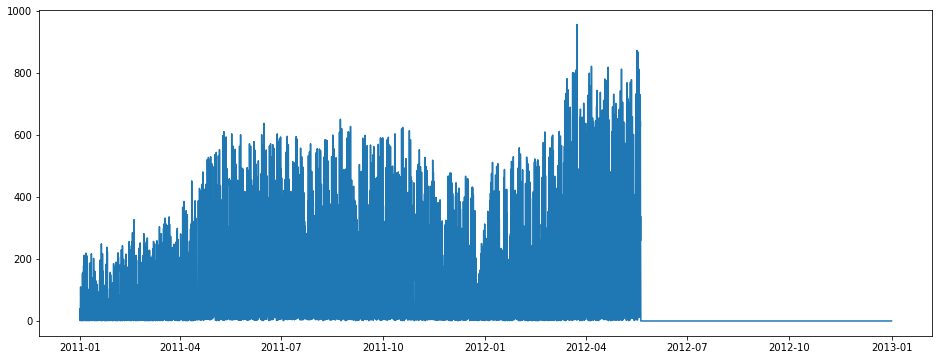

In [15]:
df_forecast = pd.concat([train_df,test_df])
df_forecast['cnt'].fillna(0, inplace = True)
df_forecast['hr'] = df_forecast['hr'].apply(lambda x: datetime.strptime(str(x), "%H").time())
df_forecast['datetime'] = pd.to_datetime(df_forecast['dteday'].astype('str') + ' ' + df_forecast['hr'].astype('str'))
plt.figure(figsize = (16, 6))
plt.plot(df_forecast['datetime'], df_forecast['cnt']);

In [16]:
target = train_df['cnt']

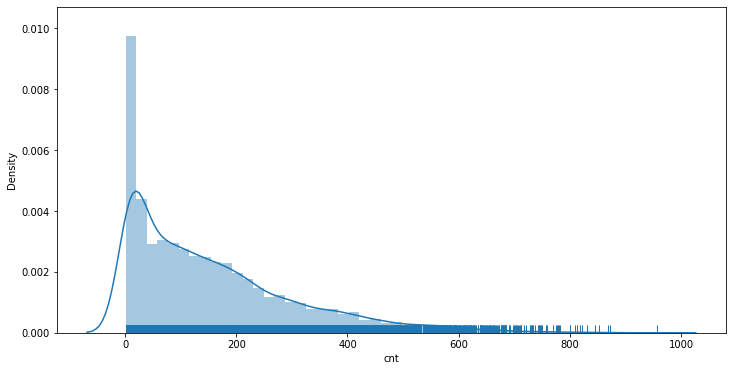

In [17]:
plt.figure(figsize=(12,6))
sns.distplot(train_df['cnt'], rug = True)
plt.show(); 

***Análisis de cuartiles***: Aplicaremos la ley de tukey.

outlier:
- q > Q1 - 1.5*IQR
- q < Q3 + 1.5*IQR

<AxesSubplot:ylabel='cnt'>

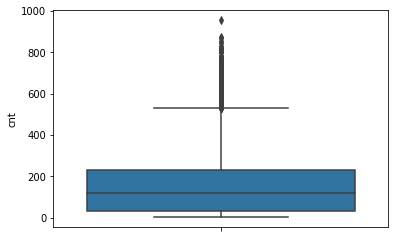

In [18]:
sns.boxplot(y = target)

In [19]:
cuartiles = pd.qcut(target, q = [0,.25,.50,.75,1], retbins = True)[1]
Q1 = cuartiles[1]
Q2 = cuartiles[2]
Q3 = cuartiles[3]
IQR = Q3 - Q1

In [20]:
outl_q = target.apply(lambda e: 1 if (e > Q3 + 1.5*IQR)|(e < Q1 - 1.5*IQR) else 0)

<AxesSubplot:xlabel='cnt', ylabel='count'>

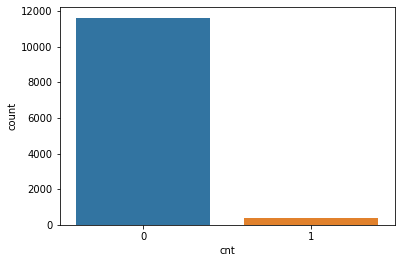

In [21]:
# Cantidad de registros (0: no outliers, 1: outliers)
sns.countplot(outl_q)

In [22]:
outl_q.value_counts()

0    11623
1      376
Name: cnt, dtype: int64

***Análisis de las 3 sigmas***: 
- mínimo = Promedio – 3 * Desviación Estándar
- máximo = Promedio + 3 * Desviación Estándar


In [23]:
std = np.std(target)
mean = np.mean(target)

In [24]:
outl_s = target.apply(lambda e: 1 if (e > mean + 3*std)|(e < mean - 3*std) else 0)

<AxesSubplot:xlabel='cnt', ylabel='count'>

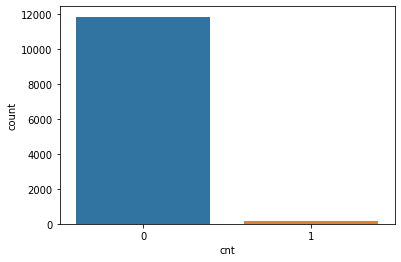

In [25]:
# Cantidad de registros (0: no outliers, 1: outliers)
sns.countplot(outl_s)

In [26]:
outl_s.value_counts()

0    11846
1      153
Name: cnt, dtype: int64

**Usaremos los resultados del análisis de tukey**, así que procedemos a crear la columna que que distingue los outlier encontrados el cual usaremos para un posterior análisis si se incluye o no en el entrenamiento del modelo

In [29]:
train_df['outlier'] = outl_q

In [30]:
train_df['outlier'].value_counts()

0    11623
1      376
Name: outlier, dtype: int64

#### Variables **predictoras**

> ***Visualización de features categóricos***

- `Categóricos`: season, workingday, weathersit, holiday, yr, mnth, hr, weekday

                         Visualización de features categóricos (train):                         


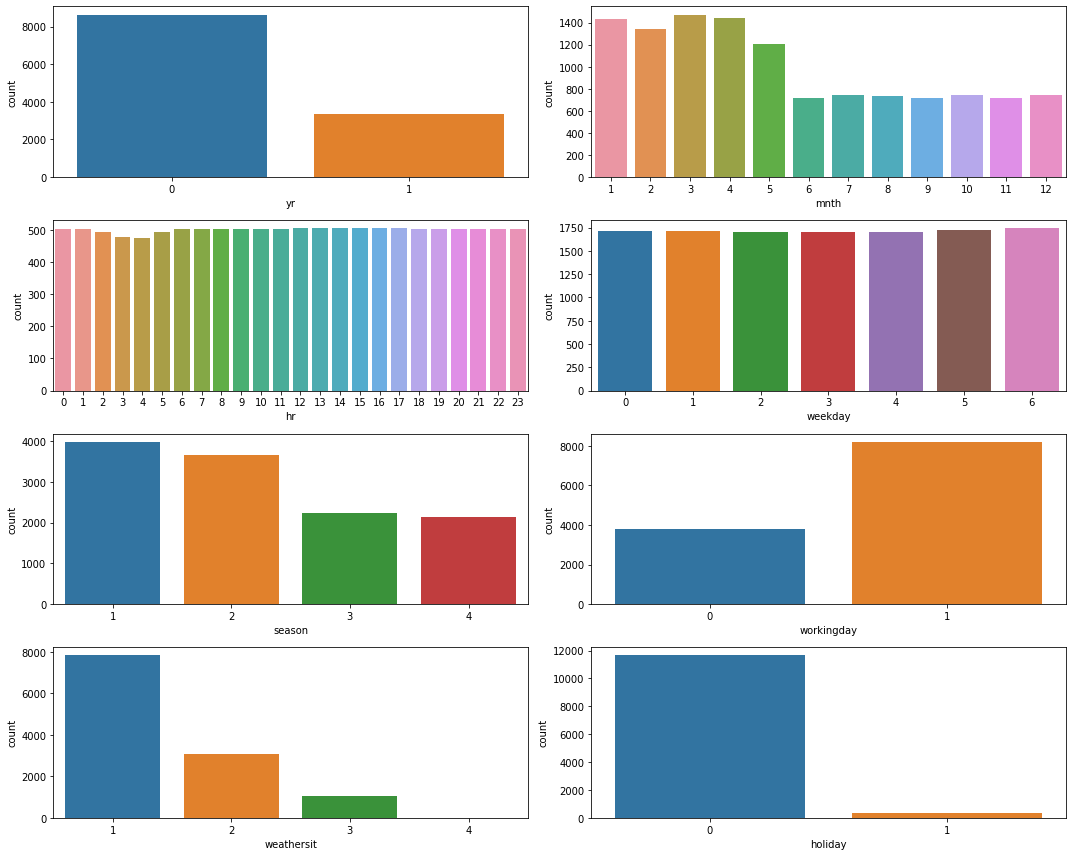

In [31]:
print('\033[1mVisualización de features categóricos (train):'.center(100))
cf = ["yr","mnth","hr","weekday","season", "workingday","weathersit","holiday"]
n = 2
plt.figure(figsize = [15,3*math.ceil(len(cf)/n)])

for i in range(len(cf)):
    if train_df[cf[i]].nunique() <= 6: # Cantidad de valores unicos de la serie df[cf[i]]
        plt.subplot(math.ceil(len(cf)/n), n, i+1)
        sns.countplot(train_df[cf[i]])
    else:
        plt.subplot(4, 2, i+1)
        sns.countplot(train_df[cf[i]])

plt.tight_layout()
plt.show()

**Nota:**  Para el entrenamiento, la `columna_valor(weathersit_4)` se descarta, solo se contará con solo 3 valores, así que se procederá a eliminar registros que contengan este valor, y además se logrará visualizar que en el conjunto de prueba este valor no existe

In [32]:
# 4: Lluvia fuerte con granizos, tormenta eléctrica y neblina, o nieve con niebla.
train_df.weathersit.value_counts()

1    7843
2    3095
3    1058
4       3
Name: weathersit, dtype: int64

In [33]:
train_df[train_df.weathersit == 4]

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,outlier
585,586,2011-01-26,1,0,1,16,0,3,1,4,0.22,0.1970,0.93,0.3284,1,35,36,0
8854,8855,2012-01-09,1,1,1,18,0,1,1,4,0.20,0.2273,0.86,0.0896,6,158,164,0
9123,9124,2012-01-21,1,1,1,1,0,6,0,4,0.14,0.1364,0.86,0.1940,1,22,23,0


                         Visualización de features categóricos (test):                          


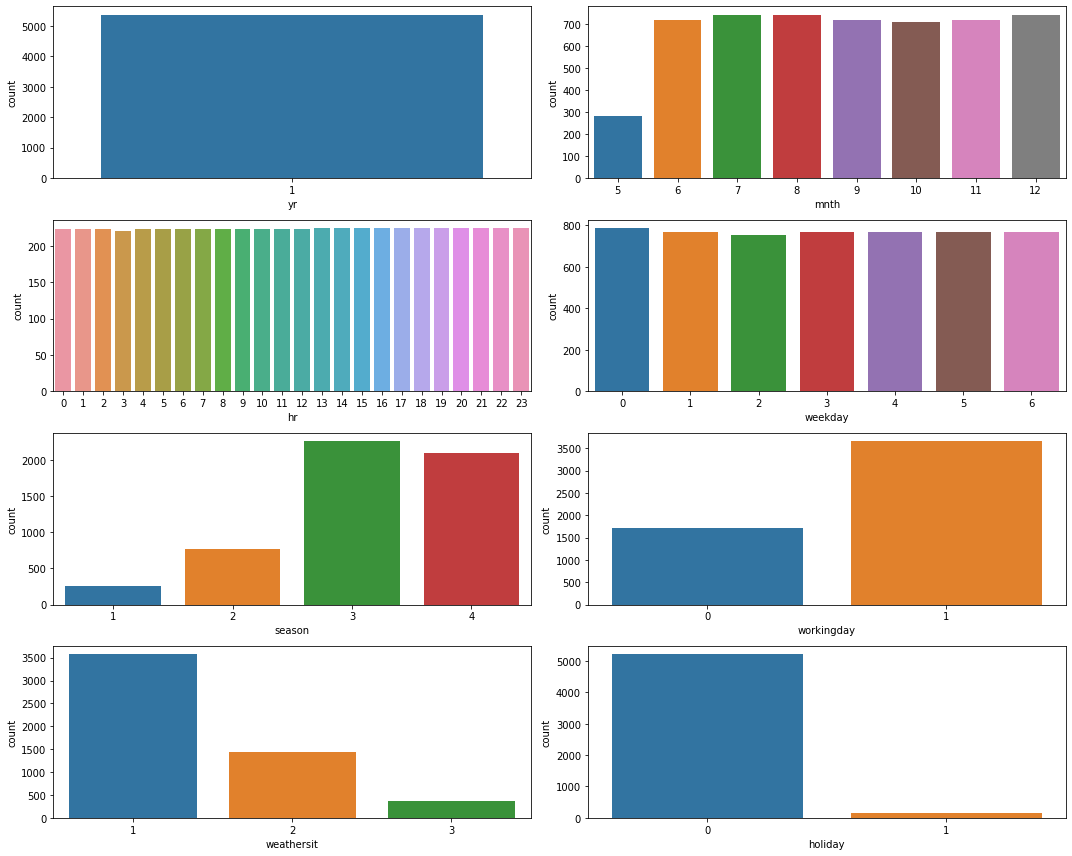

In [34]:
print('\033[1mVisualización de features categóricos (test):'.center(100))
cf = ["yr","mnth","hr","weekday","season", "workingday","weathersit","holiday"]
n = 2
plt.figure(figsize = [15,3*math.ceil(len(cf)/n)])

for i in range(len(cf)):
    if train_df[cf[i]].nunique() <= 6: # Cantidad de valores unicos de la serie df[cf[i]]
        plt.subplot(math.ceil(len(cf)/n), n, i+1)
        sns.countplot(test_df[cf[i]])
    else:
        plt.subplot(4, 2, i+1)
        sns.countplot(test_df[cf[i]])

plt.tight_layout()
plt.show()

**Nota:** En el conjunto de prueba, se cuenta con los siguientes datos:
- `mnth`: 5-12
- `wethersit`: 1-3


***Visualización de features numéricos***

                                          Distribución de features numéricos (train)                                          


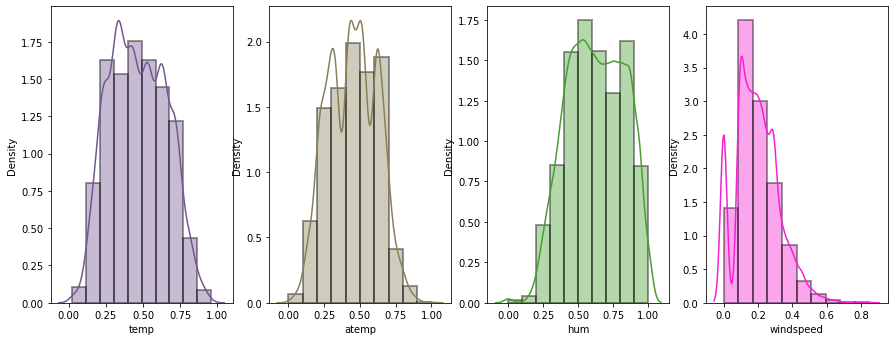

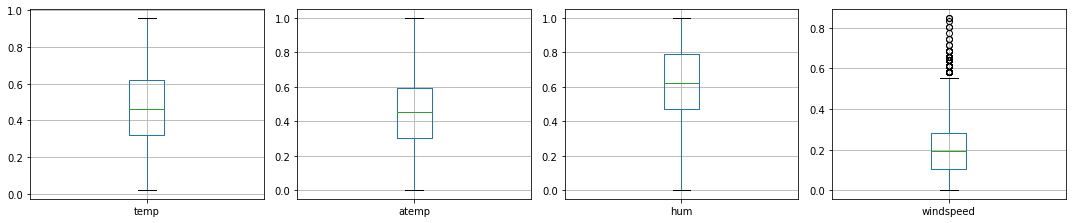

In [32]:
print('\033[1mDistribución de features numéricos (train)'.center(130))

n = 4
nf = ['temp', 'atemp', 'hum', 'windspeed']
clr = ['r', 'g', 'b', 'g', 'b', 'r']

plt.figure(figsize = [15, 6*math.ceil(len(cf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/2), n, i+1)
    sns.distplot(train_df[nf[i]], hist_kws = dict(edgecolor = 'black', linewidth = 2), 
               bins = 10, color = list(np.random.randint([255,255,255])/255))

plt.figure(figsize = [15, 6*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/2), n, i+1)
    train_df.boxplot(nf[i])

plt.tight_layout()
plt.show()

In [33]:
train_df.windspeed.count()

11999

In [34]:
cuart = pd.qcut(train_df.windspeed, q = [0,.25,.50,.75,1], retbins = True)[1]
Q1 = cuart[1]
Q2 = cuart[2]
Q3 = cuart[3]
IQR = Q3 - Q1
wind_q = train_df.windspeed.apply(lambda e: 1 if (e > Q3 + 1.5*IQR)|(e < Q1 - 1.5*IQR) else 0)

In [35]:
len(wind_q[wind_q == 1]) # 86 registros como outliers, procederemos a eliminar esos registros

86

In [36]:
train_df['outlier_wind'] = wind_q

In [37]:
train_df = train_df[train_df['outlier_wind'] == 0]

In [38]:
train_df = train_df[train_df['weathersit'] <= 3]

In [39]:
train_df.shape

(11910, 17)

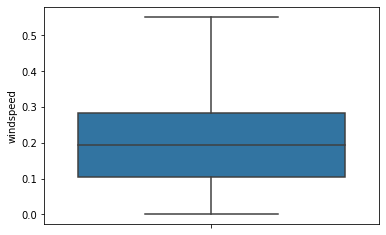

In [40]:
sns.boxplot(y = train_df['windspeed'])
plt.show()

- Los features `temp`, `atemp`, `hum`, `windspeed` parecen seguir una distribución normal, lo corroboramos mediante un intervalo de -1 a 1, mediante ciertos estadísticos.

Los estadísticos de asimetría (Skewness) y curtosis pueden emplearse para detectar desviaciones de la normalidad. Un valor de curtosis y/o coeficiente de asimetría entre -1 y 1, es generalmente considerada una ligera desviación de la normalidad. Entre -2 y 2 hay una evidente desviación de la normal pero no extrema.

In [50]:
print('Kursotis:', stats.kurtosis(train_df['atemp']))
print('Skewness:', stats.skew(train_df['atemp']))

Kursotis: -0.7631167871288271
Skewness: 0.03117693877125621


In [51]:
print('Kursotis:', stats.kurtosis(train_df['temp']))
print('Skewness:', stats.skew(train_df['temp']))

Kursotis: -0.8487548329584604
Skewness: 0.11843467382269991


In [52]:
print('Kursotis:', stats.kurtosis(train_df['hum']))
print('Skewness:', stats.skew(train_df['hum']))

Kursotis: -0.8412881286221365
Skewness: -0.09745940335350886


In [53]:
print('Kursotis:', stats.kurtosis(train_df['windspeed']))
print('Skewness:', stats.skew(train_df['windspeed']))

Kursotis: -0.17495960255027532
Skewness: 0.35420448233569496


## 4. Feature engineering
<div id='id4'/>

***Respecto a la normalización de variables:***
- Se realizó en las `variables predictoras` , siendo MinMaxScaler mejor que StandardScaler, pero de todas formas ambas contribuyen a un mrse de prueba mayor a 100, incluyendo también la aplicación del onehotencoder sobre variables categoricas
- Se realizó en la `variable objetivo` una transformación log-scale (aprox -6 a 6) y se aplicó un MinMaxScaler para mantenerla en un rango de -1 a 1 similar a las variables predictoras, pero de igual manera no contribuía a disminuir el rmse, el mejor modelo con estas configuraciones que disminuía el rmse de validación considerablemente era una red neuronal el cuál al final me generó un rmse de 145.
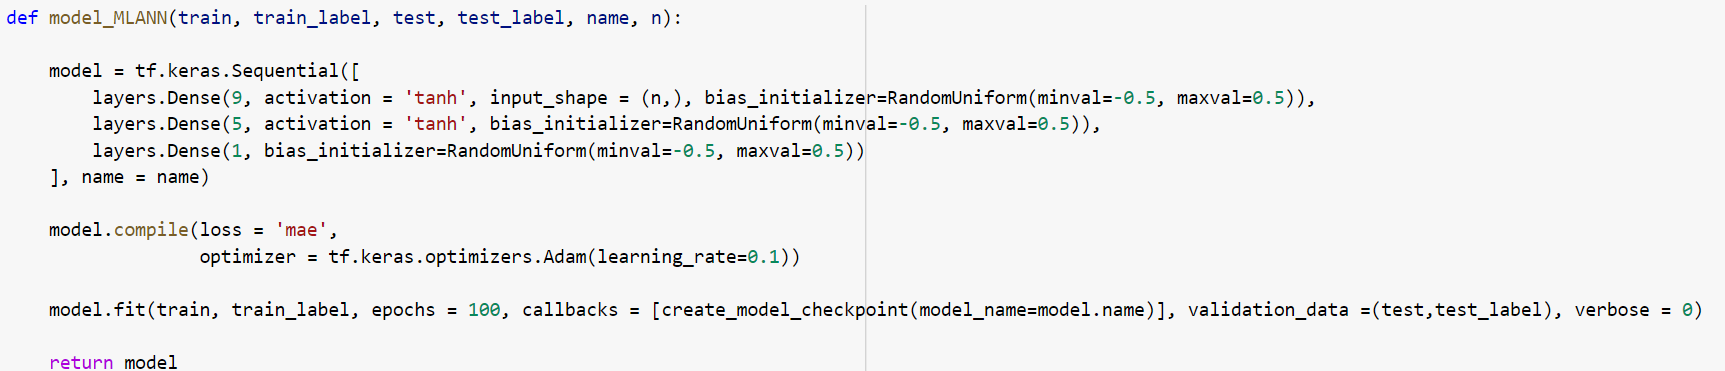

**Decisión final**: Tomar las variables categóricas en la forma por defecto que vienen (labelencoder) y de igual forma la variable `cnt` y descartar el modelo de red neuronal

Análisis previo de la matrix de correlación -> [link](#idconc)

In [41]:
train_df_prep_1 = train_df.drop(['casual','registered', 'outlier', 'outlier_wind'], axis = 1).copy()
test_prep_1 = test_df.drop(['instant', 'dteday'], axis = 1)

<AxesSubplot:xlabel='cnt', ylabel='Count'>

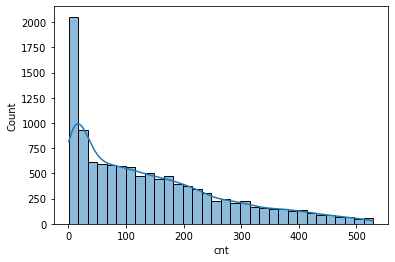

In [42]:
sns.histplot(train_df_prep_1[train_df['outlier'] == 0]['cnt'], kde=True)

Mediante le modelo Random forest, se encuentra una mejora en el rmse incluyendo los outliers de cnt, sin wathersit 4 y sin los outliers de windspeed

### Selección de features con linear regression

<div id='idfeat'/>


In [43]:
X_reg = train_df_prep_1.drop(['cnt'], axis = 1)
y_reg = train_df_prep_1['cnt']

In [44]:
X_constant = sm.add_constant(X_reg)
lin_reg = sm.OLS(y_reg, X_constant).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     600.3
Date:                Fri, 16 Sep 2022   Prob (F-statistic):               0.00
Time:                        08:22:27   Log-Likelihood:                -73887.
No. Observations:               11910   AIC:                         1.478e+05
Df Residuals:                   11897   BIC:                         1.479e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -24.2364      7.121     -3.403      0.001     -38.195     -10.278
season        12.9009      2.071      6.230      0.000       8.842      16.960
yr            86.0051      2.832     30.374      0.000      80.455      91.555
mnth           1.6074      0.657      2.445      0.015       0.319       2.896
hr             6.5293      0.167     39.083      0.000       6.202       6.857
holiday      -22.0663      6.953     -3.174      0.002     -35.695      -8.438
weekday        1.6427      0.552      2.978      0.003       0.561       2.724
workingday    -0.8062      2.445     -0.330      0.742      -5.600       3.987
weathersit    -6.2150      1.921     -3.235      0.001      -9.981      -2.449
temp          37.8913     49.246      0.769      0.442     -58.639     134.422
atemp        270.2931     54.828      4.930      0.000     162.821     377.765
hum         -149.7766      6.806    -22.005      0.000    -163.118    -136.435
windspeed     31.4026     10.227      3.070      0.002      11.355      51.450
==============================================================================
Omnibus:                     2265.235   Durbin-Watson:                   0.559
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4314.155
Skew:                           1.171   Prob(JB):                         0.00
Kurtosis:                       4.791   Cond. No.                         998.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Conclusiones:**
- Las variables no significativas (>0.05) encontradas en el modelo son:
  * `temp`
  * `workingday`

### Selección de features con Recursive Feature Elimination

Eliminación recursiva de características con validación cruzada para seleccionar características.

In [66]:
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators = 100)

selector = RFECV(model, step=3, min_features_to_select = 3, cv = 4)
selector.fit(X_reg, y_reg)

RFECV(cv=4,
      estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                             colsample_bylevel=None, colsample_bynode=None,
                             colsample_bytree=None, early_stopping_rounds=None,
                             enable_categorical=False, eval_metric=None,
                             gamma=None, gpu_id=None, grow_policy=None,
                             importance_type=None, interaction_constraints=None,
                             learning_rate=None, max_bin=None,
                             max_cat_to_onehot=None, max_delta_step=None,
                             max_depth=None, max_leaves=None,
                             min_child_weight=None, missing=nan,
                             monotone_constraints=None, n_estimators=100,
                             n_jobs=None, num_parallel_tree=None,
                             predictor=None, random_state=None, reg_alpha=None,
                             reg_lambda=None, 

In [67]:
print(X_reg.columns)
print(selector.ranking_)

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed'],
      dtype='object')
[2 1 3 1 2 2 1 1 1 1 3 3]


In [68]:
selector.grid_scores_.mean() # Todos parecen ser importantes

0.6060108038737072

**Conclusiones:**
- Las variables mas importantes son:
  * `yr`
  * `hr`
  * `workingday`
  * `weathersit`
  * `temp`
  * `atemp`
  
- Las variables menos importantes son:
  * `mnth`
  * `hum`
  * `windspeed`
  

## 5. Preprocesamiento de datos
<div id='id5'/>

In [69]:
train_df_prep_1

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11994,2,1,5,23,0,6,0,1,0.60,0.6212,0.56,0.1642,239
11995,2,1,5,0,0,0,0,1,0.58,0.5455,0.53,0.1045,170
11996,2,1,5,1,0,0,0,1,0.56,0.5303,0.52,0.0000,130
11997,2,1,5,2,0,0,0,1,0.56,0.5303,0.52,0.0000,98


### 5.1. Guiándonos de la matriz de correlación lineal

<div id='idtrainfs1'/>


Eliminamos `temp`, `mnth`, `weekday`, `holiday`, `windspeed`

In [110]:
train_prep_fs_1 = train_df_prep_1.drop(['temp','mnth', 'weekday', 'holiday', 'windspeed'],axis = 1)
test_prep_fs_1 = test_prep_1.drop(['temp','mnth', 'weekday', 'holiday', 'windspeed'],axis = 1)

In [111]:
train_prep_fs_1.columns

Index(['season', 'yr', 'hr', 'workingday', 'weathersit', 'atemp', 'hum',
       'cnt'],
      dtype='object')

#### División del conjuntos de datos, en train y validation

In [72]:
train_prep_fs_1.head()

,season,yr,hr,workingday,weathersit,atemp,hum,cnt
0,1,0,0,0,1,0.2879,0.81,16
1,1,0,1,0,1,0.2727,0.80,40
2,1,0,2,0,1,0.2727,0.80,32
3,1,0,3,0,1,0.2879,0.75,13
4,1,0,4,0,1,0.2879,0.75,1


In [112]:
# (nro. filas, nro. columnas)
train_prep_fs_1.shape

(11910, 8)

Se probará 85%(train) y 15%(test)

In [113]:
X_1 = train_prep_fs_1.drop(['cnt'], axis = 1)
y_1 = train_prep_fs_1['cnt']

In [114]:
# Se intentó yr, workingday , season, hr
hr = X_1.hr.to_numpy()
train_X_1, val_X_1, train_y_1, val_y_1 = train_test_split(X_1, y_1, test_size=0.15, random_state = 2208, stratify = hr)

[Entrenamiento Random Forest](#idrfent1)

[Entrenamiento XGBoost](#idxgent1)

[Entrenamiento Lightgbm](#idlgent1)

### 5.2. Usando el 2do método de selección mediante regresión lineal

<div id='idtrainfs2'/>


Eliminamos `mnth`,`temp` , se elige *mnth* porque tiene mayor efecto que eliminar por `season`

(probamos eliminando workingday, y el rmse de prueba llegó hasta 50.35)

(probamos sin eliminar workingday, y el rmse de prueba llegó hasta 45.8079)

In [115]:
train_prep_fs_2 = train_df_prep_1.drop(['temp','mnth'], axis = 1)
test_prep_fs_2 = test_prep_1.drop(['temp','mnth'],axis = 1)

In [116]:
train_prep_fs_2.columns

Index(['season', 'yr', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit',
       'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

#### División del conjuntos de datos, en train y validation

In [117]:
train_prep_fs_2.head()

,season,yr,hr,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt
0,1,0,0,0,6,0,1,0.2879,0.81,0.0,16
1,1,0,1,0,6,0,1,0.2727,0.80,0.0,40
2,1,0,2,0,6,0,1,0.2727,0.80,0.0,32
3,1,0,3,0,6,0,1,0.2879,0.75,0.0,13
4,1,0,4,0,6,0,1,0.2879,0.75,0.0,1


In [118]:
# (nro. filas, nro. columnas)
train_prep_fs_2.shape

(11910, 11)

Se probará 85% (train) y 15% (validación)

In [119]:
X_2 = train_prep_fs_2.drop(['cnt'], axis = 1)
y_2 = train_prep_fs_2['cnt']

In [120]:
train_X_2, val_X_2, train_y_2, val_y_2 = train_test_split(X_2, y_2, test_size=0.15, random_state = 2208, stratify = hr)

[Entrenamiento Random Forest](#idrfent2)

[Entrenamiento XGBoost](#idxgent2)

[Entrenamiento Lightgbm](#idlgent2)

### 5.3. Usando el 3er método de selección por RFECV

<div id='idtrainfs3'/>

Eliminamos `mnth`,`hum`, `windspeed`, `temp`

In [121]:
train_prep_fs_3 = train_df_prep_1.drop(['windspeed','temp', 'mnth'],axis = 1)
test_prep_fs_3 = test_prep_1.drop(['windspeed','temp', 'mnth'],axis = 1)

In [122]:
train_prep_fs_3.columns

Index(['season', 'yr', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit',
       'atemp', 'hum', 'cnt'],
      dtype='object')

#### División del conjuntos de datos, en train y validation

In [123]:
train_prep_fs_3.head()

,season,yr,hr,holiday,weekday,workingday,weathersit,atemp,hum,cnt
0,1,0,0,0,6,0,1,0.2879,0.81,16
1,1,0,1,0,6,0,1,0.2727,0.80,40
2,1,0,2,0,6,0,1,0.2727,0.80,32
3,1,0,3,0,6,0,1,0.2879,0.75,13
4,1,0,4,0,6,0,1,0.2879,0.75,1


In [124]:
# (nro. filas, nro. columnas)
train_prep_fs_3.shape

(11910, 10)

Se probará 85% (train) y 15% (validación)

In [125]:
X_3 = train_prep_fs_3.drop(['cnt'], axis = 1)
y_3 = train_prep_fs_3['cnt']

In [62]:
train_X_3, val_X_3, train_y_3, val_y_3 = train_test_split(X_3, y_3, test_size=0.15, random_state = 2208, stratify = hr)

[Entrenamiento Random Forest](#idrfent3)

[Entrenamiento XGBoost](#idxgent3)

[Entrenamiento Lightgbm](#idlgent3)

## 6. Modelos de entrenamiento
<div id='id6'/>
Se probará Modelos de Bosques aleatorios, XGboost y 

### 6.1 Random Forest
<div id='id6.1'/>

In [126]:
parameters_rf = {'n_estimators':[100, 150, 250, 300], 'max_features':['sqrt', 'log2'], 'max_depth':[20, 30, 40]}

<div id='idrfent1'/>

[Regresar](#idtrainfs1)
####  a.) Aplicando 1er método 

In [127]:
rf_1 = GridSearchCV(estimator = RandomForestRegressor(), param_grid = parameters_rf, refit = True, verbose = 2, cv = 5, scoring = 'neg_root_mean_squared_error', n_jobs = -1)

In [128]:
rf_1.fit(train_X_1, train_y_1)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [20, 30, 40],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 150, 250, 300]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [129]:
rf_1.best_estimator_

RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=300)

In [130]:
rf_1.best_score_*(-1)

49.48464991412279

In [131]:
rf_pred_1 = rf_1.predict(val_X_1)
rf_pred_1

array([194.69187306, 138.19036785, 213.22032828, ..., 313.0741686 ,
       222.013125  , 192.29278516])

In [132]:
predictions_rf_1 = pd.DataFrame(val_y_1.values.reshape(-1,1), columns=['true_val'])

In [133]:
predictions_rf_1['predict_val'] = rf_pred_1.reshape(-1,1)

In [134]:
predictions_rf_1

,true_val,predict_val
0,209,194.691873
1,144,138.190368
2,177,213.220328
3,36,46.317333
4,25,22.300008
...,...,...
1782,68,85.100000
1783,14,6.693333
1784,340,313.074169
1785,159,222.013125


In [135]:
rmse_rf_1 = round(np.sqrt(mean_squared_error(predictions_rf_1['true_val'], predictions_rf_1['predict_val'])),4)
rmse_rf_1

47.5224

<div id='idrfent2'/>

[Regresar](#idtrainfs2)
####  b.) Aplicando 2do método 

In [136]:
rf_2 = GridSearchCV(estimator = RandomForestRegressor(), param_grid = parameters_rf, refit = True, verbose = 2, cv = 5, scoring = 'neg_root_mean_squared_error', n_jobs = -1)

In [137]:
rf_2.fit(train_X_2, train_y_2)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [20, 30, 40],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 150, 250, 300]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [138]:
rf_2.best_estimator_

RandomForestRegressor(max_depth=30, max_features='sqrt', n_estimators=250)

In [139]:
rf_2.best_score_*(-1)

48.71394822177341

In [140]:
rf_pred_2 = rf_2.predict(val_X_2)
rf_pred_2

array([212.68 , 142.06 , 212.952, ..., 318.944, 225.364, 191.984])

In [141]:
predictions_rf_2 = pd.DataFrame(val_y_2.values.reshape(-1,1), columns=['true_val'])

In [142]:
predictions_rf_2['predict_val'] = rf_pred_2.reshape(-1,1)

In [143]:
predictions_rf_2

,true_val,predict_val
0,209,212.680
1,144,142.060
2,177,212.952
3,36,42.576
4,25,22.660
...,...,...
1782,68,100.432
1783,14,14.004
1784,340,318.944
1785,159,225.364


In [144]:
rmse_rf_2 = round(np.sqrt(mean_squared_error(predictions_rf_2['true_val'], predictions_rf_2['predict_val'])),4)
rmse_rf_2

47.7764

<div id='idrfent3'/>

[Regresar](#idtrainfs3)
####  c.) Aplicando 3er método 


In [145]:
rf_3 = GridSearchCV(estimator = RandomForestRegressor(), param_grid = parameters_rf, refit = True, verbose = 2, cv = 5, scoring = 'neg_root_mean_squared_error', n_jobs = -1)

In [146]:
rf_3.fit(train_X_3, train_y_3)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [20, 30, 40],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 150, 250, 300]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [147]:
rf_3.best_estimator_

RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=300)

In [148]:
# Este es
rf_3.best_score_*(-1)

44.63118763271226

In [149]:
# Este es
rf_pred_3 = rf_3.predict(val_X_3)
rf_pred_3

array([189.95559703, 141.18897079, 211.37419841, ..., 306.35721657,
       216.38407407, 173.61815233])

In [150]:
predictions_rf_3 = pd.DataFrame(val_y_3.values.reshape(-1,1), columns=['true_val'])

In [151]:
predictions_rf_3['predict_val'] = rf_pred_3.reshape(-1,1)

In [152]:
predictions_rf_3

,true_val,predict_val
0,209,189.955597
1,144,141.188971
2,177,211.374198
3,36,38.776667
4,25,25.760462
...,...,...
1782,68,94.427143
1783,14,9.019048
1784,340,306.357217
1785,159,216.384074


In [153]:
rmse_rf_3 = round(np.sqrt(mean_squared_error(predictions_rf_3['true_val'], predictions_rf_3['predict_val'])),4)
rmse_rf_3

43.1668

### 6.2 XGBoost
<div id='id6.2'/>

In [154]:
parameters_xg = {'n_estimators': [150, 200, 250], 'max_depth': [5, 10,20], 'learning_rate': [0.03, 0.05, 0.08]}

<div id='idxgent1'/>

[Regresar](#idtrainfs1)
####  a.) Aplicando 1er método 

In [155]:
xg_1 = GridSearchCV(estimator = xgb.XGBRegressor(), param_grid = parameters_xg, refit = True, scoring = 'neg_root_mean_squared_error', cv = 5, verbose = 2, n_jobs = -1)
xg_1.fit(train_X_1, train_y_1)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                  

In [156]:
xg_1.best_params_

{'learning_rate': 0.08, 'max_depth': 5, 'n_estimators': 250}

In [157]:
xg_1.best_score_*(-1)

41.82757518983002

In [158]:
# Este es
xg_pred_1 = xg_1.predict(val_X_1)
xg_pred_1

array([192.32559, 172.22624, 210.20699, ..., 309.71918, 214.93173,
       172.32494], dtype=float32)

In [159]:
predictions_xg_1 = pd.DataFrame(val_y_1.values.reshape(-1,1), columns=['true_val'])

In [160]:
predictions_xg_1['predict_val'] = xg_pred_1.reshape(-1,1)

In [161]:
predictions_xg_1

,true_val,predict_val
0,209,192.325592
1,144,172.226242
2,177,210.206985
3,36,51.081783
4,25,21.627111
...,...,...
1782,68,78.002350
1783,14,15.985504
1784,340,309.719177
1785,159,214.931732


In [162]:
rmse_xg_1 = round(np.sqrt(mean_squared_error(predictions_xg_1['true_val'], predictions_xg_1['predict_val'])),4)
rmse_xg_1

40.8224

<div id='idxgent2'/>

[Regresar](#idtrainfs2)
####  b.) Aplicando 2do método 

In [163]:
xg_2 = GridSearchCV(estimator = xgb.XGBRegressor(), param_grid = parameters_xg, refit = True, scoring = 'neg_root_mean_squared_error', cv = 5, verbose = 2, n_jobs = -1)
xg_2.fit(train_X_2, train_y_2)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                  

In [164]:
xg_2.best_params_

{'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 150}

In [165]:
xg_2.best_score_*(-1)

37.01935018368933

In [166]:
# Este es
xg_pred_2 = xg_2.predict(val_X_2)
xg_pred_2

array([191.51715, 153.58208, 224.0367 , ..., 310.64697, 160.36253,
       157.45332], dtype=float32)

In [167]:
predictions_xg_2 = pd.DataFrame(val_y_2.values.reshape(-1,1), columns=['true_val'])

In [168]:
predictions_xg_2['predict_val'] = xg_pred_2.reshape(-1,1)

In [169]:
predictions_xg_2

,true_val,predict_val
0,209,191.517151
1,144,153.582077
2,177,224.036697
3,36,37.320965
4,25,25.808088
...,...,...
1782,68,83.501694
1783,14,6.015658
1784,340,310.646973
1785,159,160.362534


In [170]:
rmse_xg_2 = round(np.sqrt(mean_squared_error(predictions_xg_2['true_val'], predictions_xg_2['predict_val'])),4)
rmse_xg_2

36.6484

<div id='idxgent3'/>

[Regresar](#idtrainfs3)
####  c.) Aplicando 3er método 

In [171]:
xg_3 = GridSearchCV(estimator = xgb.XGBRegressor(), param_grid = parameters_xg, refit = True, scoring = 'neg_root_mean_squared_error', cv = 5, verbose = 2, n_jobs = -1)
xg_3.fit(train_X_3, train_y_3)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                  

In [172]:
xg_3.best_params_

{'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 150}

In [173]:
xg_3.best_score_*(-1)

37.85038782277344

In [174]:
# Este es
xg_pred_3 = xg_3.predict(val_X_3)
xg_pred_3

array([185.46144, 144.93971, 217.46864, ..., 300.13516, 161.32338,
       153.0289 ], dtype=float32)

In [175]:
predictions_xg_3 = pd.DataFrame(val_y_3.values.reshape(-1,1), columns=['true_val'])

In [176]:
predictions_xg_3['predict_val'] = xg_pred_3.reshape(-1,1)

In [177]:
predictions_xg_3

,true_val,predict_val
0,209,185.461441
1,144,144.939713
2,177,217.468643
3,36,35.344494
4,25,25.992727
...,...,...
1782,68,94.899490
1783,14,6.337852
1784,340,300.135162
1785,159,161.323380


In [178]:
rmse_xg_3 = round(np.sqrt(mean_squared_error(predictions_xg_3['true_val'], predictions_xg_3['predict_val'])),4)
rmse_xg_3

36.4138

### 6.3 Lightgbm
<div id='id6.3'/>

In [179]:
# Antes solo 150,250,300
parameters_light = {'n_estimators': [150, 250, 300, 350], 'max_depth': [10,20,30], 'learning_rate': [0.03, 0.05, 0.08]}

<div id='idlgent1'/>

[Regresar](#idtrainfs1)
####  a.) Aplicando 1er método 

In [180]:
lg_1 = GridSearchCV(estimator = LGBMRegressor(), param_grid = parameters_light, refit = True, scoring = 'neg_root_mean_squared_error', cv = 5, verbose = 2, n_jobs = -1)
lg_1.fit(train_X_1, train_y_1)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.03, 0.05, 0.08],
                         'max_depth': [10, 20, 30],
                         'n_estimators': [150, 250, 300, 350]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [181]:
lg_1.best_params_

{'learning_rate': 0.08, 'max_depth': 20, 'n_estimators': 350}

In [182]:
lg_1.best_score_*(-1)

40.59624695530389

In [183]:
# Este es
lg_pred_1 = lg_1.predict(val_X_1)
lg_pred_1

array([196.59975276, 171.46509817, 213.52602771, ..., 299.29188501,
       220.97977491, 182.04563862])

In [184]:
predictions_lg_1 = pd.DataFrame(val_y_1.values.reshape(-1,1), columns=['true_val'])

In [185]:
predictions_lg_1['predict_val'] = lg_pred_1.reshape(-1,1)

In [186]:
predictions_lg_1

,true_val,predict_val
0,209,196.599753
1,144,171.465098
2,177,213.526028
3,36,47.781680
4,25,22.775804
...,...,...
1782,68,75.585220
1783,14,8.411977
1784,340,299.291885
1785,159,220.979775


In [187]:
rmse_lg_1 = round(np.sqrt(mean_squared_error(predictions_lg_1['true_val'], predictions_lg_1['predict_val'])),4)
rmse_lg_1

39.9531

<div id='idlgent2'/>

[Regresar](#idtrainfs2)
####  b.) Aplicando 2do método 

In [188]:
lg_2 = GridSearchCV(estimator = xgb.XGBRegressor(), param_grid = parameters_light, refit = True, scoring = 'neg_root_mean_squared_error', cv = 5, verbose = 2, n_jobs = -1)
lg_2.fit(train_X_2, train_y_2)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                  

In [189]:
lg_2.best_params_

{'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 150}

In [190]:
lg_2.best_score_*(-1)

37.01935018368933

In [191]:
# Este es
lg_pred_2 = lg_2.predict(val_X_2)
lg_pred_2

array([191.51715, 153.58208, 224.0367 , ..., 310.64697, 160.36253,
       157.45332], dtype=float32)

In [192]:
predictions_lg_2 = pd.DataFrame(val_y_2.values.reshape(-1,1), columns=['true_val'])

In [193]:
predictions_lg_2['predict_val'] = lg_pred_2.reshape(-1,1)

In [194]:
predictions_lg_2

,true_val,predict_val
0,209,191.517151
1,144,153.582077
2,177,224.036697
3,36,37.320965
4,25,25.808088
...,...,...
1782,68,83.501694
1783,14,6.015658
1784,340,310.646973
1785,159,160.362534


In [195]:
rmse_lg_2 = round(np.sqrt(mean_squared_error(predictions_lg_2['true_val'], predictions_lg_2['predict_val'])),4)
rmse_lg_2

36.6484

<div id='idlgent3'/>

[Regresar](#idtrainfs3)
####  c.) Aplicando 3er método 

In [196]:
lg_3 = GridSearchCV(estimator = xgb.XGBRegressor(), param_grid = parameters_light, refit = True, scoring = 'neg_root_mean_squared_error', cv = 5, verbose = 2, n_jobs = -1)
lg_3.fit(train_X_3, train_y_3)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                  

In [197]:
lg_3.best_params_

{'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 150}

In [198]:
lg_3.best_score_*(-1)

37.85038782277344

In [199]:
np.sqrt(mean_squared_error(train_y_3,lg_3.predict(train_X_3)))

15.447400913509544

In [221]:
# Este es
lg_pred_3 = lg_3.predict(val_X_3)
lg_pred_3

array([185.46144, 144.93971, 217.46864, ..., 300.13516, 161.32338,
       153.0289 ], dtype=float32)

In [222]:
predictions_lg_3 = pd.DataFrame(val_y_3.values.reshape(-1,1), columns=['true_val'])

In [223]:
predictions_lg_3['predict_val'] = lg_pred_3.reshape(-1,1)

In [224]:
predictions_lg_3

,true_val,predict_val
0,209,185.461441
1,144,144.939713
2,177,217.468643
3,36,35.344494
4,25,25.992727
...,...,...
1782,68,94.899490
1783,14,6.337852
1784,340,300.135162
1785,159,161.323380


In [225]:
rmse_lg_3 = round(np.sqrt(mean_squared_error(predictions_lg_3['true_val'], predictions_lg_3['predict_val'])),4)
rmse_lg_3

36.4138

## 7. Pruebas
<div id='id7'/>

In [205]:
pd.DataFrame([[rmse_rf_1, rmse_xg_1, rmse_lg_1],
              [rmse_rf_2, rmse_xg_2, rmse_lg_2],
              [rmse_rf_3, rmse_xg_3, rmse_lg_3]], columns = ['Random Forest', 'XGBoost', 'Lightgbm'], index = ['1er met', '2do met', '3er met'])

,Random Forest,XGBoost,Lightgbm
1er met,47.5224,40.8224,39.9531
2do met,47.7764,36.6484,36.6484
3er met,43.1668,36.4138,36.4138


In [206]:
test_prep_fs_3.head()

,season,yr,hr,holiday,weekday,workingday,weathersit,atemp,hum
0,2,1,4,0,0,0,1,0.5000,0.68
1,2,1,5,0,0,0,1,0.4848,0.72
2,2,1,6,0,0,0,1,0.4848,0.63
3,2,1,7,0,0,0,1,0.5000,0.68
4,2,1,8,0,0,0,1,0.5303,0.56


In [207]:
test = lg_3.predict(test_prep_fs_3)

In [209]:
test = test.reshape(-1,1)
test

array([[ 12.891632],
       [ 11.589813],
       [ 17.237732],
       ...,
       [112.87046 ],
       [102.744286],
       [ 42.353058]], dtype=float32)

In [210]:
prueba = pd.DataFrame(np.round(test), columns = ['pred'])

In [211]:
prueba

,pred
0,13.0
1,12.0
2,17.0
3,63.0
4,149.0
...,...
5375,239.0
5376,163.0
5377,113.0
5378,103.0


<AxesSubplot:ylabel='Count'>

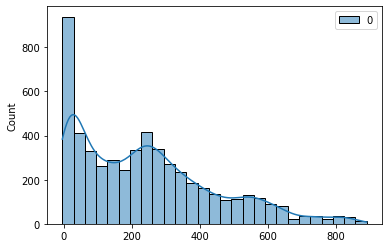

In [212]:
sns.histplot(test, kde=True);

In [213]:
prueba.to_csv('Sandtw.csv', header=True, index=False)

***Stacked Generalization***

In [226]:
def get_stacking():
    level0 = list()
    level0.append(('rf', rf_3.best_estimator_))
    level0.append(('xgb', xg_3.best_estimator_))
    level0.append(('lgb', lg_3.best_estimator_))
    level1 = LinearRegression()
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

In [ ]:
model = get_stacking()
model.fit(train_X_3, train_y_3)

In [ ]:
yhat = model.predict(val_X_3)